# Survival of the Fittest

This Notebook contains the exploration of how to place a large variety of players into tournament-style matches to see which players have optimal strategies.

Note that the code in this Notebook has been moved to individual files in the `src` directory. Please refer to that code, only using the code here as a reference.

In [1]:
import sys
sys.path.append("../..")

In [2]:
from classes.player import Player
from classes.board import Board
from classes.referee import Referee
from classes.game import Game

# Import the rulesets and strategy
from graph_coloring.classes.gc_ruleset import GCRuleset
from graph_coloring.classes.gc_simple_smart_strategy import GCSimpleSmartStrategy
from graph_coloring.classes.gc_random_strategy import GCRandomStrategy
from graph_coloring.classes.gc_data_strategy import GCDataStrategy
from graph_coloring.classes.gc_random_init_strategy import GCRandomInitStrategy

## Concepts

Our end goal is to create evolving players that use optimal strategies in any game they are placed in. This is an enourmous goal with much room for error. To begin, we will need to take this in smaller steps.

We will consider 3 core ideas:

1. Generating a population of players with random strategies
2. Placing players in a tournament to eliminate weak contestants
3. Extracting the winner's strategy of a particular game

## Generating a Population

The simplest way to implement this is to create a function that automates this process and returns a list of our players. Let's call it `generate_population`.

To generate a population, we need a few pieces of information:
* How many players to generate?
* What kind of strategies will be created?
* How will these strategies be created?

The first point is easily solved by passing in a parameter to our function. The other two are more complicated. We *can* make this function fairly generic, generating a strategy based on an existing strategy from the game. This is what will be attempted. 

To understand this better, let's look at what we expect the function to return if we implemented it for the Graph Coloring Game:
```
strategy = ExampleStrategy()

players = generate_population(num_players=4, strategy, player_to_gen=1)

for player in players:
    print(player)
```

We expect an output where the following are true:
* Every player has a unique name
* Every strategy has a unique identifier
* Color or vertex orderings can be repeated, but not both

In [3]:
from random import sample
from copy import deepcopy

def generate_population(num_players, strategy, player_to_gen):
    """
    Generates a population of players with random strategies for the
    Graph Coloring Game.
    
    Args:
        num_players : The number of players to create
        strategy : An example strategy for the game being played
        player_to_gen : 1 or 2, depending on what population we are generating
    
    Return:
        A list of players with random strategies
    """
    # A list to hold the strategies
    strategies = []
    generated = 0
    failures = 0
    max_attempts = 10 * num_players
    
    while generated < num_players:
        # Clone the example strategy
        strat = deepcopy(strategy)

        # Shuffle the orderings in the data
        new_data = {}
        for key in strat.data.keys():
            new_data[key] = sample(strat.data[key], len(strat.data[key]))
            
        # Update the data of the new strategy
        strat.set_data(new_data)
        
        # Only append unique strategies
        if strat not in strategies:
            strategies.append(strat)
            generated += 1
        else:
            failures += 1
                    
        # Exit if it is taking too long to create players
        if failures >= max_attempts:
            print("Error: Failed to create unique players {} times. Aborting".format(failures))
            break 

    # A list to hold the players
    players = []
    # Generate a new player for every strategy
    for strat in strategies:
        player = Player("Player {}".format(player_to_gen), strat)
        # Strategies are unique, so we don't need to check player uniqueness
        players.append(player)
        generated += 1

    return players

We can check our code by running the example function call from earlier:

In [4]:
num_players = 8
num_vertices = 11
num_colors = 3

data = {"vertices": list(range(num_vertices)), "colors": list(range(1, num_colors + 1))}
strategy = GCDataStrategy("Basic Data Strategy", data)

p1_pop = generate_population(num_players, strategy, player_to_gen=1)
p2_pop = generate_population(num_players, strategy, player_to_gen=2)

for player1 in p1_pop:
    print(player1)
    
print()
for player2 in p2_pop:
    print(player2)

Player 1: Basic Data Strategy: {'vertices': [8, 5, 6, 1, 4, 2, 10, 0, 7, 3, 9], 'colors': [3, 1, 2]}
Gen: 0 Wins: 0 Losses: 0
Player 1: Basic Data Strategy: {'vertices': [3, 5, 6, 8, 10, 9, 2, 4, 1, 0, 7], 'colors': [1, 2, 3]}
Gen: 0 Wins: 0 Losses: 0
Player 1: Basic Data Strategy: {'vertices': [1, 5, 4, 7, 10, 9, 8, 6, 3, 2, 0], 'colors': [2, 3, 1]}
Gen: 0 Wins: 0 Losses: 0
Player 1: Basic Data Strategy: {'vertices': [3, 7, 1, 2, 6, 8, 5, 9, 4, 10, 0], 'colors': [1, 3, 2]}
Gen: 0 Wins: 0 Losses: 0
Player 1: Basic Data Strategy: {'vertices': [5, 2, 7, 3, 8, 4, 6, 9, 1, 0, 10], 'colors': [1, 3, 2]}
Gen: 0 Wins: 0 Losses: 0
Player 1: Basic Data Strategy: {'vertices': [3, 5, 6, 10, 8, 1, 7, 4, 2, 0, 9], 'colors': [1, 2, 3]}
Gen: 0 Wins: 0 Losses: 0
Player 1: Basic Data Strategy: {'vertices': [4, 5, 7, 1, 3, 6, 2, 10, 0, 9, 8], 'colors': [2, 3, 1]}
Gen: 0 Wins: 0 Losses: 0
Player 1: Basic Data Strategy: {'vertices': [0, 8, 4, 10, 2, 5, 3, 6, 9, 7, 1], 'colors': [3, 1, 2]}
Gen: 0 Wins: 0 Lo

Seems to be working correctly! Now onto our next task: the tournament.

## Tournament

A tournament is a simple concept: Two players compete against each other, and the winner moves up in the ranks to continue competing. For our needs, the tournaments will be the same no matter what game is being played. As such, as can write this to be generic function, let's call it `compete()`. Additionally, we want every player1 to compete against every player2 in a small sample of the player 2 population. This is to ensure good performance when dealing with large-scale populations.

We want the function to do a few specific things:
1. Pick a Player 1 from the Player 1 Population
2. Player 1 competes, one game at a time, with every Player 2 in the Player 2 sample
3. Player 1's win percentage is recorded
4. If Player 1's win percent is below the `fitness` threshold, remove it from the population
5. Repeat steps 1-5 until the "best" players are found

Let's begin

In [5]:
from random import choice, shuffle

def compete(p1_pop, p2_pop, ruleset, num_games = 10, fitness = 0.8):
    """
    Places all players in a ranked tournament against each other
    to determine the best players.
    
    Args:
        p1_pop : Player 1 population to compete in the tournament
        p2_pop : Player 2 population to compete in the tournament
        ruleset : Ruleset of the game being played
        num_games : (Optional) The number of games for each player to play
        fitness : (Optional) Percentage of wins players need to be considered "good"
    
    Return:
        Two lists, each containing the "best" Player 1s and Player 2s, respectively
    """
    board = Board(ruleset.initial_state, ruleset.bounds)

    ref = Referee(board, ruleset)

    # Create lists to hold the "best" players
    best_p1s = eliminate(p1_pop, p2_pop, num_games, ref, board, fitness, True)
    best_p2s = eliminate(p2_pop, p1_pop, num_games, ref, board, fitness, False)
    
    return sorted(best_p1s, reverse=True), sorted(best_p2s, reverse=True)

def eliminate(player_pop, opponent_pop, num_games, referee, board, fitness, player_is_p1):
    """
    Competes all players against a random sample of opponents and eliminates
    players who do not meet the fitness critera.
    
    Args:
        player_pop : Population of players to compete
        opponent_pop : Population of opponents to sample from
        num_games : Number of games to play
        referee : Referee of the game
        board : Board being played on
        fitness : Win percentage required to survive
        player_is_p1 : Whether the `player_pop` is a Player 1 population
    """
    # Create a list of elite/best players
    elite = []
    
    for player in player_pop:
        # Get a random sample of opponents
        opponent_sample = sample(opponent_pop, min(len(opponent_pop), num_games))
        
        # Every player must play every opponent in the sample
        for opponent in opponent_sample:
            # Order the players based on p1/p2 status
            players = [player, opponent] if player_is_p1 else [opponent, player]
            
            # Create and play the game
            game = Game(referee, board, players)
            board = game.play()

        # Only append players whose fitness at least the threshold
        if player.fitness() >= fitness:
            elite.append(player)
            
    return elite

Now we can test our function by providing simple game parameters:

In [6]:
initial_state = [
    {"color": 0, "adj": [1, 2]},
    {"color": 0, "adj": [0, 2, 3]},
    {"color": 0, "adj": [0, 1, 3, 6]},
    {"color": 0, "adj": [1, 2, 5]},
    {"color": 0, "adj": [5]},
    {"color": 0, "adj": [3, 4, 9]},
    {"color": 0, "adj": [2, 7, 9]},
    {"color": 0, "adj": [6, 8, 9]},
    {"color": 0, "adj": [7]},
    {"color": 0, "adj": [6, 7, 10]},
    {"color": 0, "adj": [9]},
]
bounds = 3
ruleset =  GCRuleset("Graph Coloring Ruleset", initial_state, bounds)

And by calling our function on our ruleset.

In [7]:
best_p1s, best_p2s = compete(p1_pop, p2_pop, ruleset, fitness=.5)

for best_p1 in best_p1s:
    print(best_p1)
print()
for best_p2 in best_p2s:
    print(best_p2)

Player 1: Basic Data Strategy: {'vertices': [3, 5, 6, 8, 10, 9, 2, 4, 1, 0, 7], 'colors': [1, 2, 3]}
Gen: 0 Wins: 12 Losses: 4
Player 1: Basic Data Strategy: {'vertices': [3, 5, 6, 10, 8, 1, 7, 4, 2, 0, 9], 'colors': [1, 2, 3]}
Gen: 0 Wins: 12 Losses: 4
Player 1: Basic Data Strategy: {'vertices': [8, 5, 6, 1, 4, 2, 10, 0, 7, 3, 9], 'colors': [3, 1, 2]}
Gen: 0 Wins: 10 Losses: 6
Player 1: Basic Data Strategy: {'vertices': [1, 5, 4, 7, 10, 9, 8, 6, 3, 2, 0], 'colors': [2, 3, 1]}
Gen: 0 Wins: 10 Losses: 6
Player 1: Basic Data Strategy: {'vertices': [3, 7, 1, 2, 6, 8, 5, 9, 4, 10, 0], 'colors': [1, 3, 2]}
Gen: 0 Wins: 10 Losses: 6
Player 1: Basic Data Strategy: {'vertices': [5, 2, 7, 3, 8, 4, 6, 9, 1, 0, 10], 'colors': [1, 3, 2]}
Gen: 0 Wins: 8 Losses: 8

Player 2: Basic Data Strategy: {'vertices': [2, 5, 8, 0, 10, 6, 1, 3, 9, 7, 4], 'colors': [3, 2, 1]}
Gen: 0 Wins: 14 Losses: 2
Player 2: Basic Data Strategy: {'vertices': [3, 9, 8, 6, 4, 7, 0, 2, 5, 1, 10], 'colors': [3, 1, 2]}
Gen: 0 Win

All seems to be working. Now, if we want to iterate over this, we simply call this function in a loop, updating our `players` list repeatedly.

### Interlude

Right now the code is a little scattered, so let's re-type the code to have a much more concise example. We will use the graph below

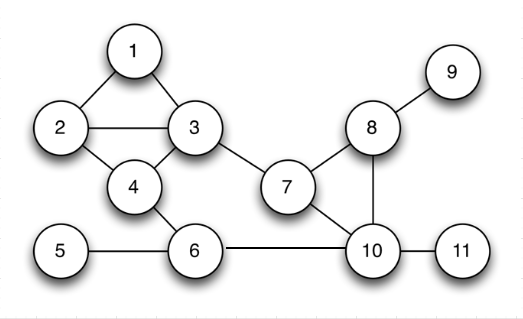

In [8]:
# Create a graph to play on
initial_state = [
    {"color": 0, "adj": [1, 2]},
    {"color": 0, "adj": [0, 2, 3]},
    {"color": 0, "adj": [0, 1, 3, 6]},
    {"color": 0, "adj": [1, 2, 5]},
    {"color": 0, "adj": [5]},
    {"color": 0, "adj": [3, 4, 9]},
    {"color": 0, "adj": [2, 7, 9]},
    {"color": 0, "adj": [6, 8, 9]},
    {"color": 0, "adj": [7]},
    {"color": 0, "adj": [6, 7, 10]},
    {"color": 0, "adj": [9]},
]

# Create our ruleset using the graph and bounds
ruleset =  GCRuleset("Graph Coloring Ruleset", initial_state, bounds = 3)
data = {"vertices": range(len(ruleset.initial_state)), "colors": range(1, ruleset.bounds + 1)}
strategy = GCDataStrategy("Basic Data Strategy", data)

# Create a population of players with random strategies
num_players = 16
p1_pop = generate_population(num_players, strategy, player_to_gen=1)
p2_pop = generate_population(num_players, strategy, player_to_gen=2)

for i in range(3):
    p1_pop, p2_pop = compete(p1_pop, p2_pop, ruleset, fitness=0.4)

for p1 in p1_pop:
    print(p1)
    
for p2 in p2_pop:
    print(p2)

Player 1: Basic Data Strategy: {'vertices': [2, 10, 7, 5, 0, 9, 1, 3, 6, 4, 8], 'colors': [3, 1, 2]}
Gen: 0 Wins: 36 Losses: 7
Player 1: Basic Data Strategy: {'vertices': [1, 10, 6, 9, 8, 7, 4, 3, 5, 2, 0], 'colors': [1, 2, 3]}
Gen: 0 Wins: 33 Losses: 12
Player 1: Basic Data Strategy: {'vertices': [9, 2, 5, 3, 10, 1, 7, 6, 8, 0, 4], 'colors': [3, 2, 1]}
Gen: 0 Wins: 33 Losses: 15
Player 1: Basic Data Strategy: {'vertices': [1, 6, 2, 9, 8, 4, 5, 3, 10, 0, 7], 'colors': [1, 2, 3]}
Gen: 0 Wins: 30 Losses: 15
Player 1: Basic Data Strategy: {'vertices': [2, 8, 6, 4, 3, 7, 5, 10, 1, 9, 0], 'colors': [2, 1, 3]}
Gen: 0 Wins: 30 Losses: 18
Player 1: Basic Data Strategy: {'vertices': [7, 8, 9, 6, 5, 10, 0, 2, 3, 1, 4], 'colors': [1, 3, 2]}
Gen: 0 Wins: 27 Losses: 21
Player 1: Basic Data Strategy: {'vertices': [6, 3, 5, 10, 8, 9, 4, 1, 0, 2, 7], 'colors': [3, 1, 2]}
Gen: 0 Wins: 23 Losses: 18
Player 1: Basic Data Strategy: {'vertices': [4, 5, 0, 3, 7, 9, 8, 2, 6, 10, 1], 'colors': [1, 2, 3]}
Gen:

Now that our code is clear and concise, let's move on to the next big step...

## Reproduction

Evolution is nothing without reproduction. Two individuals will produce an offspring that is mostly a random combination of the traits from both parents. We say "mostly" here because there can be minor amounts of mutation.

Two have two players reproduce, we need to extract each player's strategy, splice them together, and produce a new player from it.

Consider the following two players, which will be used as parents:
```
Player 1: Strategy: {'vertices': [7, 4, 5, 1, 2, 6, 9, 0, 10, 8, 3], 'colors': [2, 3, 4, 1]}
Player 2: Strategy: {'vertices': [9, 10, 0, 1, 2, 3, 5, 8, 4, 7, 6], 'colors': [2, 3, 1, 4]}
```
We have two strategies, `[7, 4, 5, 1, 2, 6, 9, 0, 10, 8, 3]` and `[9, 10, 0, 1, 2, 3, 5, 8, 4, 7, 6]`.

An "offspring" of these two players will include a strategy that is a combination of these two strategies. We will begin splicing these two strategies by choosing a `crossover` point. The `crossover` point should be randomly chosen and be somewhere after the first element and before the last element, so that a mix of qualities from both parents is ensured.

For our example, let's choose index 3 as our `crossover` point. Everything *before* the `crossover` will be chosen from the first parent, and everything *after* the `crossover` point will be chosen from the second. Because we are working with graphs, we need to ensure that no duplicate entries exist (meaning no duplicate vertices are included in the strategy). To do this, we carefully pick information from the second parent that has not been provided from the first example. This can be broken down into steps:
1. Choose a crossover point `c`
2. Extract all data up to and including point `c` from the first parent
3. Iterate over the second parent's data from the beginning
4. Take data bit-by-bit, excluding any data provided by the first parent
5. Once all data points have been collected, splice the two strings. 

Once the newly-spliced data is created, this process can be repeated for every other trait possessed by the parents (such as the color ordering), and a new child can be created with the newly-generated data.

In [13]:
from random import random, randrange
from copy import deepcopy

def spawn(parent1, parent2, child_name, child_strat_name, mutation_rate = .0025):
    """
    Spawns a new `Player` instance using the provided players
    as parents.
    
    Args:
        parent1 : The first parent
        parent2 : The second parent
        child_name : The name of the child-to-be
        child_strat_name : The name of the child's strategy
        mutation_rate : Percentage for a mutation to occur
    
    Return:
        A new `Player` with traits from both parents
    """
    # Get all the data 
    traits = parent1.strategy.data.keys()
    
    child_traits = {}
    for trait in traits:
        # Obtain the current trait from both parents
        p1_trait = parent1.strategy.data[trait]
        p2_trait = parent2.strategy.data[trait]
        
        # Randomly generated crossover point
        crossover = randrange(0, len(p1_trait))       
        
        # Choose up to the crossover from parent 1
        p1_inherit = p1_trait[:crossover]
        
        # Choose the rest of the genes from parent 2
        p2_inherit = [gene for gene in p2_trait if gene not in p1_inherit]
        
        # Assemble child's trait
        child_trait = p1_inherit + p2_inherit
        
        # Mutation Check: If mutation occurs, swap two genes
        if random() < mutation_rate:
            index1, index2 = sample(range(len(p1_trait)), 2)
            child_trait[index1], child_trait[index2] = child_trait[index2], child_trait[index1]
        
        # Construct the child's traits
        child_traits[trait] = child_trait
    
    child_strat = deepcopy(parent1.strategy)
    child_strat.set_name(child_strat_name)
    child_strat.set_data(child_traits)
    
    child = Player(child_name, child_strat)
    child.generation = max(parent1.generation, parent2.generation) + 1
    
    return child

With our function in place, let's try facilitating reproduction between two players from `p1_pop`.

In [15]:
parent1 = p1_pop[0]
parent2 = p1_pop[1]

print(parent1)
print(parent2)
print()

child = spawn(parent1, parent2, "First Child", "Child Strategy")
print(child)

Player 1: Basic Data Strategy: {'vertices': [2, 10, 7, 5, 0, 9, 1, 3, 6, 4, 8], 'colors': [3, 1, 2]}
Gen: 0 Wins: 36 Losses: 7
Player 1: Basic Data Strategy: {'vertices': [1, 10, 6, 9, 8, 7, 4, 3, 5, 2, 0], 'colors': [1, 2, 3]}
Gen: 0 Wins: 33 Losses: 12

First Child: Child Strategy: {'vertices': [2, 10, 7, 5, 1, 6, 9, 8, 4, 3, 0], 'colors': [3, 1, 2]}
Gen: 1 Wins: 0 Losses: 0


Excellent! Reproduction works as expected. With the added bonus of mutation, as well. Now that the code is all in place, we can commence streamlining it into a simple function.

## Natural Selection

Our end goal is to have a function that takes in as few parameters as possible and returns to use the best players for our game. This function will need to perform all of the tasks listed in the Notebook so far, with a few extra steps. Luckily, we can reuse all of the functions written earlier.

Let's review what needs to happen:
1. Generate a random population of both players
2. Compete both populations against each other
3. Remove "bad" players who did not have a high enough win percentage
4. Breed elite players to fill the gap left in the population
5. Repeat steps 2-4 until a threshold has been met
6. Return both populations of elite players

In [23]:
from random import sample

def evolve(pop_size, ruleset, strategy, generations, num_games = 10, mutation_rate = 0.025, fitness = 0.5, max_fitness = 0.9, fitness_increment = 0.05, verbose = False):
    """
    Generates random populations of players and evolves them across a specified
    number of generations.
    Evolution is composed of competing players, eliminating poor performers,
    and reproducing good players with each other to produce optimal children.
    
    Args:
        pop_size : Size of the populations to generate
        ruleset : The ruleset of the game to play on
        strategy : An example strategy to generate populations from
        generations : Number of generations to evolve players
        num_games : (Optional) Minimum number of games each player must play per generation
        mutation_rate : (Optional) Percentage to mutation to occur
        initial_fitness : (Optional) Initial minimum win percentage to continue playing
        max_fitness : (Optional) Maximum fitness to test players against
        fitness_increment : (Optional) What to increment the fitness by after each iteration
        verbose : (Optional) Whether to print debug information
        
    Return:
        Two lists, containing the elite P1 and P2 populations, respectively
    """
    # Create populations of players with random strategies
    p1_pop = generate_population(pop_size, strategy, 1)
    p2_pop = generate_population(pop_size, strategy, 2)
    
    for i in range(generations):
        # Compete both populations against each other
        p1_pop, p2_pop = compete(p1_pop, p2_pop, ruleset, num_games, fitness)

        if verbose:
            print("\nITERATION: {}, FITNESS: {}".format(i, round(fitness, 4)))
            print("\tP1 Pop: " + str(len(p1_pop)))
            print("\tP2 Pop: " + str(len(p2_pop)))

        # Repopulate p1_pop
        repopulate(p1_pop, pop_size, 1, ruleset, mutation_rate, verbose)
        repopulate(p2_pop, pop_size, 2, ruleset, mutation_rate, verbose)
       
        # Never increase fitness beyond 90%
        if fitness < max_fitness:
            fitness += fitness_increment
                    
    # Return the elite players
    return p1_pop, p2_pop

def repopulate(pop, pop_size, pop_id, ruleset, mutation_rate, verbose):
    """
    Breeds a depleted population until its capacity is reached again.
    
    Args:
        pop : The population to reproduce from
        pop_size : The capacity of the population
        pop_id : The player ID of the population; 1 or 2
        ruleset : Ruleset of the game being played
        mutation_rate : Percentage that a mutation will occur
        verbose : Whether to print debug information
        
    Return:
        A list of children to add to the population
    """
    # Keep track of number of children made
    child_counter = 0
    
    while len(pop) < pop_size:
        child_counter += 1

        # If the population is too low, repopulate randomly
        if len(pop) < 2:
            if verbose:
                print("WARNING: Player {} population too low! Repopulating randomly".format(pop_id))
            pop += generate_population(pop_size // 2, strategy, pop_id)

        # Get two random parents
        parent1, parent2 = sample(pop, 2)

        # Name the child and its strategy
        child_name = "Player {} #{}.{}".format(pop_id, i, child_counter)
        child_strat_name = "Evolved Strategy #{}".format(child_counter)

        # Create the child
        child = spawn(parent1, parent2, child_name, child_strat_name, mutation_rate)

        # Add the new child to the population
        pop.append(child)

    pop.sort(reverse=True)

Now let's test everything on a sample game.

In [24]:
# Create a graph to play on
initial_state = [
    {"color": 0, "adj": [1, 2]},
    {"color": 0, "adj": [0, 2, 3]},
    {"color": 0, "adj": [0, 1, 3, 6]},
    {"color": 0, "adj": [1, 2, 5]},
    {"color": 0, "adj": [5]},
    {"color": 0, "adj": [3, 4, 9]},
    {"color": 0, "adj": [2, 7, 9]},
    {"color": 0, "adj": [6, 8, 9]},
    {"color": 0, "adj": [7]},
    {"color": 0, "adj": [6, 7, 10]},
    {"color": 0, "adj": [9]},
]

# Create our ruleset and strategy using the graph and bounds
ruleset =  GCRuleset("Graph Coloring Ruleset", initial_state, bounds=3)
data = {"vertices": range(len(ruleset.initial_state)), "colors": range(1, ruleset.bounds + 1)}
strategy = GCDataStrategy("Basic Data Strategy", data)

p1_pop, p2_pop = evolve(pop_size=128, ruleset=ruleset, strategy=strategy, generations=10, fitness=.5, verbose=True)


ITERATION: 0, FITNESS: 0.5
	P1 Pop: 80
	P2 Pop: 65

ITERATION: 1, FITNESS: 0.55
	P1 Pop: 69
	P2 Pop: 44

ITERATION: 2, FITNESS: 0.6
	P1 Pop: 61
	P2 Pop: 39

ITERATION: 3, FITNESS: 0.65
	P1 Pop: 34
	P2 Pop: 49

ITERATION: 4, FITNESS: 0.7
	P1 Pop: 27
	P2 Pop: 18

ITERATION: 5, FITNESS: 0.75
	P1 Pop: 20
	P2 Pop: 31

ITERATION: 6, FITNESS: 0.8
	P1 Pop: 32
	P2 Pop: 1

ITERATION: 7, FITNESS: 0.85
	P1 Pop: 26
	P2 Pop: 3

ITERATION: 8, FITNESS: 0.9
	P1 Pop: 3
	P2 Pop: 11

ITERATION: 9, FITNESS: 0.9
	P1 Pop: 99
	P2 Pop: 0


In [ ]:
for p1 in p1_pop:
    print(p1)
print()
for p2 in p2_pop:
    print(p2)